In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


# K-modes
import kmodes

# 나무
from sklearn.tree import export_graphviz
import graphviz

# 데이터 분할
from sklearn.model_selection import train_test_split

# 예측 모형: Logistic regression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC

from sklearn.model_selection import GridSearchCV

# 평가 함수
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score


# https://pypi.org/project/kmodes/
from kmodes.kmodes import KModes

%matplotlib inline
matplotlib.rc('font', family = 'NanumBarunGothic')

path = '/home/pirl/BDAI-정덕성/Group/Python/'
list_files = ['user.csv', 'address.csv', 'contract.csv']

In [2]:
df = pd.read_csv(path + 'merged_final.csv', engine='python', encoding = 'euc-kr')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49645 entries, 0 to 49644
Data columns (total 23 columns):
gender              49645 non-null object
customerType        49645 non-null object
age                 49645 non-null object
marital             49645 non-null object
residence           49645 non-null object
channel             49645 non-null object
credit              49645 non-null object
payment             49645 non-null object
paymentCO           49645 non-null object
province            49645 non-null object
provinceIS          49645 non-null object
cityGrade           49645 non-null object
channelType         49645 non-null object
contractExtended    49645 non-null object
contractType        49645 non-null object
contractType_1      49645 non-null object
contractType_2      49645 non-null object
cityGradeIS         49645 non-null object
Termination_str     49645 non-null object
maxDay_str          49645 non-null object
maxGift_str         49645 non-null object
Terminati

## X & Y 분리

In [173]:
df_tree = df.drop(['channel', # channelType 사용
                   'credit', 'payment', 'paymentCO', # 경향성 없음
                   'province', 'cityGrade', # 실거주지 정보 제외
                   'contractExtended', 'Termination_rate', # 목표변수 파생변수 제외
                   'contractType_1', 'contractType_2', # 6개 범주 사용
                   'maxDay_str', 'overDue_str'], axis=1) # 경향성 없음             
                                  
# X, Y 분리 & Dummy 변수
df_tree_y = pd.get_dummies(df_tree[['Termination_str']], drop_first=True)
df_tree_y = df_tree_y.replace({0:1, 1:0})
df_tree_y.rename(columns = {'Termination_str_중도 해약 X': '중도해지'}, inplace = True)

In [174]:
df_tree_y.columns

Index(['중도해지'], dtype='object')

In [175]:
df_tree_s = pd.get_dummies(df_tree.drop('Termination_str', axis=1))
df_tree_s_short = pd.get_dummies(df_tree.drop('Termination_str', axis=1),
                                 drop_first = True)

In [176]:
df_tree_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49645 entries, 0 to 49644
Data columns (total 1 columns):
중도해지    49645 non-null int64
dtypes: int64(1)
memory usage: 387.9 KB


In [177]:
# 나무 데이터
df_train_s, df_test_s, df_train_y, df_test_y = train_test_split(df_tree_s_short, df_tree_y, test_size = 0.3)

print('train data X size:{}'.format(df_train_s.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('test data X size:{}'.format(df_test_s.shape))
print('test data Y size:{}'.format(df_test_y.shape))


train data X size:(34751, 30)
train data Y size:(34751, 1)
test data X size:(14894, 30)
test data Y size:(14894, 1)


### 기본 나무 점수

In [67]:
tree_final = DTC()
tree_final.fit(df_train_s, df_train_y)
y_pred = tree_final.predict(df_test_s)

# 예측 정확도 (AUC)
false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc.round(3)

0.648

In [65]:
params = {'max_depth':'',
          'min_samples_leaf':'',
          'min_samples_split':'',
          'max_features': ''}

### 최대 깊이

,Depth,TrainScore,TestScore
0,15,0.800,0.629
1,16,0.832,0.632
2,17,0.852,0.635
3,18,0.870,0.640
4,19,0.885,0.641
5,20,0.901,0.647
6,21,0.909,0.644
7,22,0.915,0.648
8,23,0.917,0.648
9,24,0.919,0.649


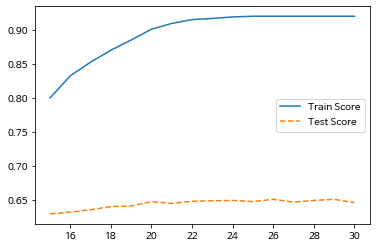

In [40]:
# Train/Test Score 저장할 list
train_results = []; test_results = []

# max_depth
para_depth = [depth for depth in range(15, 31)]


for v_max_depth in para_depth:
    tree = DTC(max_depth = v_max_depth)
    tree.fit(df_train_s, df_train_y)
    
    # Train Fit
    train_pred = tree.predict(df_train_s)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(df_train_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # Add auc score to previous train results
    train_results.append(roc_auc)

    # Test Fit
    test_pred = tree.predict(df_test_s)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # Add auc score to previous test results
    test_results.append(roc_auc)
    
    
df_score_depth = pd.DataFrame({'Depth': para_depth,
                               'TrainScore': train_results,
                               'TestScore': test_results})

plt.plot(para_depth, train_results, linestyle='-', label="Train Score")
plt.plot(para_depth, test_results, linestyle='--', label="Test Score")

plt.legend()

df_score_depth.round(3)

### 최대 깊이 = 26

In [73]:
params['max_depth'] = 26

### 최소 분리노드 크기

,split,TrainScore,TestScore
0,4,0.864,0.649
1,6,0.819,0.647
2,8,0.783,0.635
3,10,0.753,0.627
4,12,0.730,0.624
5,14,0.714,0.618
6,16,0.687,0.605
7,18,0.667,0.598
8,20,0.657,0.597
9,22,0.648,0.594


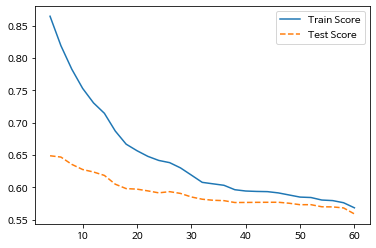

In [54]:
# Train/Test Score 저장할 list
train_results = []; test_results = []

# max_split
para_split = [split*2 for split in range(2, 31)]


for v_max_split in para_split:
    tree = DTC(# max_depth = params['max_depth'],
               min_samples_split = v_max_split)
    
    tree.fit(df_train_s, df_train_y)
    
    # Train Fit
    train_pred = tree.predict(df_train_s)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(df_train_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # Add auc score to previous train results
    train_results.append(roc_auc)

    # Test Fit
    test_pred = tree.predict(df_test_s)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # Add auc score to previous test results
    test_results.append(roc_auc)
    
    
df_score_split = pd.DataFrame({'split': para_split,
                               'TrainScore': train_results,
                               'TestScore': test_results})

plt.plot(para_split, train_results, linestyle='-', label="Train Score")
plt.plot(para_split, test_results, linestyle='--', label="Test Score")

plt.legend()

df_score_split.round(3)

In [71]:
params['min_samples_split'] = 4

### 최소 최종노드 크기

,leaf,TrainScore,TestScore
0,1,0.920,0.645
1,2,0.856,0.652
2,3,0.753,0.624
3,4,0.717,0.624
4,5,0.665,0.598
5,6,0.660,0.598
6,7,0.640,0.588
7,8,0.626,0.589
8,9,0.614,0.585
9,10,0.605,0.577


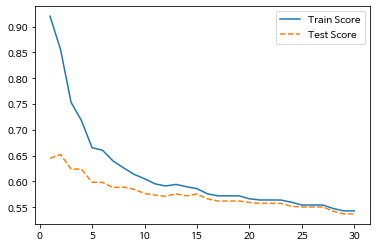

In [58]:
# Train/Test Score 저장할 list
train_results = []; test_results = []

# max_leaf
para_leaf = [leaf for leaf in range(1, 31)]


for v_max_leaf in para_leaf:
    tree = DTC(max_depth = params['max_depth'],
               min_samples_leaf = v_max_leaf)
    
    tree.fit(df_train_s, df_train_y)
    
    # Train Fit
    train_pred = tree.predict(df_train_s)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(df_train_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # Add auc score to previous train results
    train_results.append(roc_auc)

    # Test Fit
    test_pred = tree.predict(df_test_s)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # Add auc score to previous test results
    test_results.append(roc_auc)
    
    
df_score_leaf = pd.DataFrame({'leaf': para_leaf,
                               'TrainScore': train_results,
                               'TestScore': test_results})

plt.plot(para_leaf, train_results, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_results, linestyle='--', label="Test Score")

plt.legend()

df_score_leaf.round(3)

In [70]:
params['min_samples_leaf'] = 2

### 최대 변수

,feature,TrainScore,TestScore
0,1,0.92,0.614
1,2,0.92,0.609
2,3,0.92,0.626
3,4,0.92,0.634
4,5,0.92,0.625
5,6,0.92,0.638
6,7,0.92,0.641
7,8,0.92,0.643
8,9,0.92,0.649
9,10,0.92,0.638


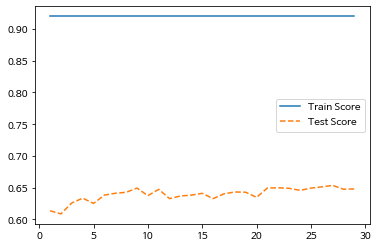

In [64]:
# Train/Test Score 저장할 list
train_results = []; test_results = []

# max_feature
para_feature = [feature for feature in range(1,df_train_s.shape[1])]


for v_max_feature in para_feature:
    tree = DTC(# max_depth = params['max_depth'],
               max_features = v_max_feature)
    
    tree.fit(df_train_s, df_train_y)
    
    # Train Fit
    train_pred = tree.predict(df_train_s)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(df_train_y, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # Add auc score to previous train results
    train_results.append(roc_auc)

    # Test Fit
    test_pred = tree.predict(df_test_s)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, test_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    # Add auc score to previous test results
    test_results.append(roc_auc)
    
    
df_score_feature = pd.DataFrame({'feature': para_feature,
                               'TrainScore': train_results,
                               'TestScore': test_results})

plt.plot(para_feature, train_results, linestyle='-', label="Train Score")
plt.plot(para_feature, test_results, linestyle='--', label="Test Score")

plt.legend()

df_score_feature.round(3)

In [69]:
params['max_features'] = 27

## 최종 나무

In [109]:
dt_final = DTC(max_depth = params['max_depth'],
               min_samples_leaf = params['min_samples_leaf'],
               min_samples_split = params['min_samples_split'],
               max_features = params['max_features'])

dt_final.fit(df_train_s, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=26,
                       max_features=27, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [158]:
y_pred = dt_final.predict(df_test_s)

# AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

# f1 score
f1Score = f1_score(df_test_y, y_pred)

print('AUC: {0:.3f}\n'.format(roc_auc))
print('F1: {0:.3f}\n'.format(f1Score))
print('Accuracy: {0:.3f}\n'.format(accuracy_score(df_test_y, y_pred)))
print('Confusion Mat:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

AUC: 0.646

F1: 0.967

Accuracy: 0.937

Confusion Mat:
[[  193   392]
 [  543 13766]]


# 랜덤포레스트

In [111]:
rf_uncustomized = RFC()
rf_uncustomized.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [112]:
print('Accuracy on Training: {0:.3f}\n'.format(rf_uncustomized.score(df_train_s, df_train_y)))
print('Accuracy on Test: {0:.3f}\n'.format(rf_uncustomized.score(df_test_s, df_test_y)))

Accuracy on Training: 0.985

Accuracy on Test: 0.955



### 숲의 나무 수

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was e

,N_Tree,TrainScore,TestScore
0,10,0.985,0.955
1,20,0.986,0.957
2,30,0.987,0.958
3,40,0.987,0.958
4,50,0.987,0.959
5,60,0.987,0.959
6,70,0.987,0.958
7,80,0.987,0.959
8,90,0.987,0.959
9,100,0.987,0.959


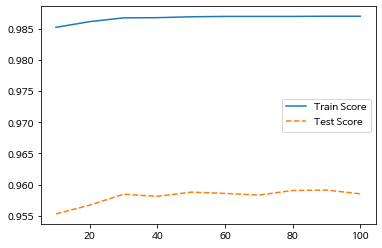

In [113]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []

# ntree
para_ntree = [10*ntree for ntree in range(1, 11)]


for v_ntree in para_ntree:
    rf = RFC(n_estimators = v_ntree)
    rf.fit(df_train_s, df_train_y)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    
    
df_score_ntree = pd.DataFrame({'N_Tree': para_ntree,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy})

plt.plot(para_ntree, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_ntree, test_accuracy, linestyle='--', label="Test Score")
plt.legend()

df_score_ntree.round(3)

### 나무의 최대 깊이

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d

,Depth,TrainScore,TestScore
0,10,0.960,0.962
1,11,0.960,0.963
2,12,0.962,0.963
3,13,0.965,0.964
4,14,0.969,0.964
5,15,0.972,0.963


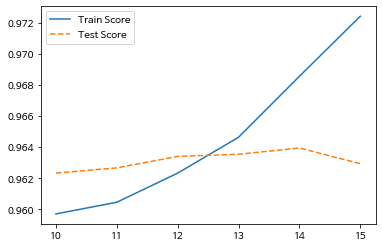

In [115]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []

# max_depth
para_depth = [depth for depth in range(10, 16)]


for v_max_depth in para_depth:
    rf = RFC(n_estimators = 100,
             max_depth = v_max_depth)
    rf.fit(df_train_s, df_train_y)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    
    
df_score_depth = pd.DataFrame({'Depth': para_depth,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy})

plt.plot(para_depth, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_depth, test_accuracy, linestyle='--', label="Test Score")
plt.legend()

df_score_depth.round(3)

### 최소 잎사귀 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys

,MinLeafSize,TrainScore,TestScore
0,10,0.960,0.962
1,20,0.958,0.961
2,30,0.958,0.961
3,40,0.957,0.961
4,50,0.957,0.961


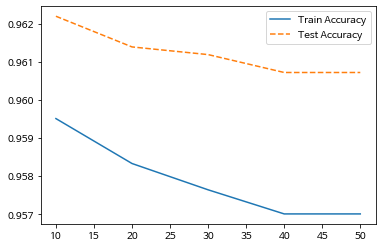

In [116]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []

# max_depth
para_leaf = [leaf*10 for leaf in range(1, 6)]


for v_leaf in para_leaf:
    rf = RFC(n_estimators = 100,
             max_depth = 14,
             min_samples_leaf = v_leaf)
    rf.fit(df_train_s, df_train_y)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    
    
df_score_leaf = pd.DataFrame({'MinLeafSize': para_leaf,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy})


plt.plot(para_leaf, train_accuracy, linestyle='-', label="Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle='--', label="Test Accuracy")
plt.legend()
df_score_leaf.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys

,MinsplitSize,TrainScore,TestScore
0,20,0.96,0.963
1,30,0.96,0.963
2,40,0.96,0.963
3,50,0.96,0.962


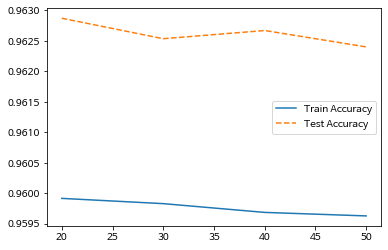

In [119]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []

# max_depth
para_split = [split*10 for split in range(2, 6)]


for v_split in para_split:
    rf = RFC(n_estimators = 100,
             max_depth = 14,
             min_samples_split = v_split)
    rf.fit(df_train_s, df_train_y)
    train_accuracy.append(rf.score(df_train_s, df_train_y))
    test_accuracy.append(rf.score(df_test_s, df_test_y))
    
    
df_score_split = pd.DataFrame({'MinsplitSize': para_split,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy})


plt.plot(para_split, train_accuracy, linestyle='-', label="Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle='--', label="Test Accuracy")
plt.legend()
df_score_split.round(3)

In [179]:
rf_final = RFC(n_estimators = 100,
               max_depth = 24, min_samples_leaf=2, min_samples_split=4)
rf_final.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=24, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [180]:
y_pred = rf_final.predict(df_test_s)

# AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

# f1 score
f1Score = f1_score(df_test_y, y_pred)

print('AUC: {0:.3f}\n'.format(roc_auc))
print('F1: {0:.3f}\n'.format(f1Score))
print('Accuracy: {0:.3f}\n'.format(accuracy_score(df_test_y, y_pred)))
print('Confusion Mat:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

AUC: 0.558

F1: 0.206

Accuracy: 0.964

Confusion Mat:
[[14285    10]
 [  529    70]]


In [128]:
df_importance = pd.DataFrame()
v_feature_name = df_train_s.columns
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_ # TREECLASS.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
1,customerType_PERSONAL,0.181
18,channelType_총판,0.086
3,age_40대,0.048
6,marital_SINGLE,0.048
24,cityGradeIS_2급지,0.047
2,age_30대,0.041
0,gender_MALE,0.038
8,residence_HOUSE,0.037
4,age_50대,0.035
9,residence_OFFICETEL,0.035


Text(0, 0.5, '변수')

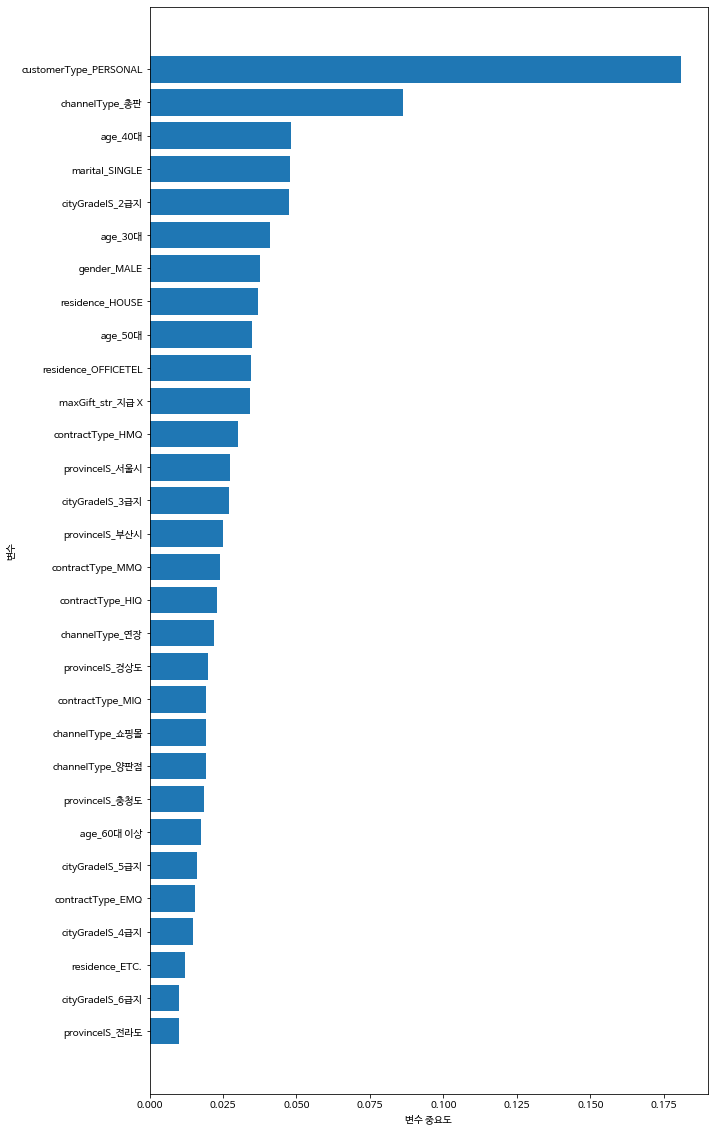

In [129]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.figure(figsize=(10,20))

plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

# GBC

In [130]:
gb_uncustomized = GBC()
gb_uncustomized.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [131]:
print('Accuracy on Training: {0:.3f}\n'.format(gb_uncustomized.score(df_train_s, df_train_y)))
print('Accuracy on Test: {0:.3f}\n'.format(gb_uncustomized.score(df_test_s, df_test_y)))

Accuracy on Training: 0.960

Accuracy on Test: 0.963



In [132]:
params = {'learning_rate':'',
          'max_depth':'',
          'min_samples_leaf':'',
          'min_samples_split':'',
          'n_estimators':''}

### Learning Rate

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d

,L_Rate,TrainScore,TestScore
6,0.7,0.963,0.964
4,0.5,0.962,0.964
3,0.4,0.961,0.964
5,0.6,0.963,0.963
2,0.3,0.961,0.963
1,0.2,0.960,0.963
0,0.1,0.960,0.963
8,0.9,0.958,0.961
7,0.8,0.957,0.960
9,1.0,0.953,0.954


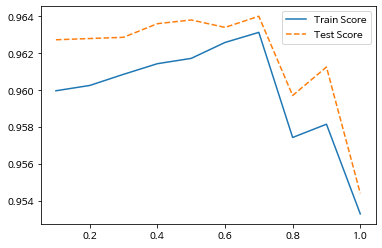

In [133]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []

# max_depth
para_lrate = [lrate/10 for lrate in range(1, 11)]


for v_lrate in para_lrate:
    gb = GBC(learning_rate = v_lrate)
    gb.fit(df_train_s, df_train_y)
    train_accuracy.append(gb.score(df_train_s, df_train_y))
    test_accuracy.append(gb.score(df_test_s, df_test_y))
    
    
df_score_lrate = pd.DataFrame({'L_Rate': para_lrate,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy})

plt.plot(para_lrate, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_lrate, test_accuracy, linestyle='--', label="Test Score")
plt.legend()

df_score_lrate.sort_values('TestScore', ascending = False).round(3)

#### LR = 0.5

In [134]:
params['learning_rate'] = 0.7

### 숲의 나무의 수

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d

,N_Tree,TrainScore,TestScore
0,100,0.963138,0.964012
1,110,0.963224,0.964214
2,120,0.963598,0.964348
3,130,0.963713,0.964281
4,140,0.963771,0.964147
5,150,0.963886,0.964617


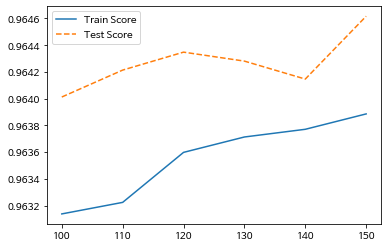

In [135]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []

# max_depth
para_ntree = [ntree*10 for ntree in range(10, 16)]


for v_max_ntree in para_ntree:
    gb = GBC(learning_rate = params['learning_rate'],
             n_estimators = v_max_ntree)
    gb.fit(df_train_s, df_train_y)
    train_accuracy.append(gb.score(df_train_s, df_train_y))
    test_accuracy.append(gb.score(df_test_s, df_test_y))
    
    
df_score_ntree = pd.DataFrame({'N_Tree': para_ntree,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy})

plt.plot(para_ntree, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_ntree, test_accuracy, linestyle='--', label="Test Score")
plt.legend()

df_score_ntree.round(6)

In [136]:
## n_estimators = 40
params['n_estimators'] = 150

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d

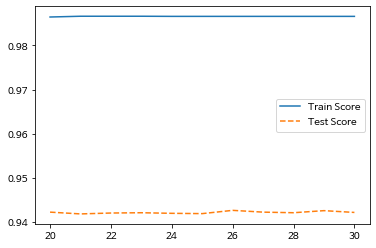

In [137]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []

# max_depth
para_depth = [depth for depth in range(20, 31)]


for v_max_depth in para_depth:
    gb = GBC(learning_rate = params['learning_rate'],
             n_estimators = params['n_estimators'],
             max_depth = v_max_depth)
    gb.fit(df_train_s, df_train_y)
    train_accuracy.append(gb.score(df_train_s, df_train_y))
    test_accuracy.append(gb.score(df_test_s, df_test_y))
    
    
df_score_depth = pd.DataFrame({'Depth': para_depth,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy})

plt.plot(para_depth, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_depth, test_accuracy, linestyle='--', label="Test Score")
plt.legend()



In [138]:
df_score_depth.sort_values('TestScore', ascending = False).round(3)

,Depth,TrainScore,TestScore
6,26,0.987,0.943
9,29,0.987,0.943
0,20,0.986,0.942
7,27,0.987,0.942
10,30,0.987,0.942
3,23,0.987,0.942
8,28,0.987,0.942
2,22,0.987,0.942
4,24,0.987,0.942
5,25,0.987,0.942


In [141]:
## max_depth
params['max_depth'] = 26

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d

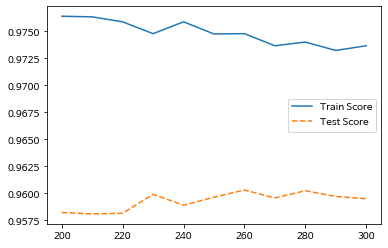

In [142]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []

# max_depth
para_leaf = [leaf*10 for leaf in range(20, 31)]


for v_leaf in para_leaf:
    gb = GBC(learning_rate = params['learning_rate'],
             n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_leaf = v_leaf)
    gb.fit(df_train_s, df_train_y)
    train_accuracy.append(gb.score(df_train_s, df_train_y))
    test_accuracy.append(gb.score(df_test_s, df_test_y))
    
    
df_score_leaf = pd.DataFrame({'MinleafSize': para_leaf,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy})


plt.plot(para_leaf, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_accuracy, linestyle='--', label="Test Score")
plt.legend()

In [143]:
df_score_leaf.sort_values('TestScore', ascending = False).round(6)

,MinleafSize,TrainScore,TestScore
6,260,0.974792,0.960320
8,280,0.974015,0.960252
3,230,0.974792,0.959917
9,290,0.973238,0.959715
5,250,0.974763,0.959648
7,270,0.973670,0.959581
10,300,0.973670,0.959514
4,240,0.975886,0.958910
0,200,0.976404,0.958238
2,220,0.975886,0.958171


In [144]:
## max_depth
params['min_samples_leaf'] = 260

### 분리 노드 최소 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d

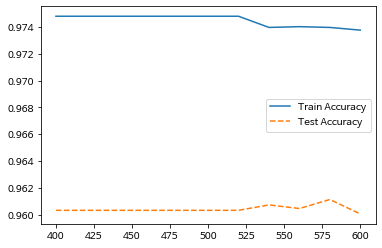

In [145]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []

# max_depth
para_split = [split*20 for split in range(20, 31)]


for v_split in para_split:
    gb = GBC(learning_rate = params['learning_rate'],
             n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = v_split)
    gb.fit(df_train_s, df_train_y)
    train_accuracy.append(gb.score(df_train_s, df_train_y))
    test_accuracy.append(gb.score(df_test_s, df_test_y))
    
    
df_score_split = pd.DataFrame({'MinsplitSize': para_split,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy})


plt.plot(para_split, train_accuracy, linestyle='-', label="Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle='--', label="Test Accuracy")
plt.legend()


In [146]:
df_score_split.round(6)

,MinsplitSize,TrainScore,TestScore
0,400,0.974792,0.960320
1,420,0.974792,0.960320
2,440,0.974792,0.960320
3,460,0.974792,0.960320
4,480,0.974792,0.960320
5,500,0.974792,0.960320
6,520,0.974792,0.960320
7,540,0.973958,0.960722
8,560,0.974015,0.960454
9,580,0.973958,0.961125


In [147]:
params['min_samples_split'] = 400

### 최종 모형

In [148]:
gb_final = GBC(learning_rate = params['learning_rate'],
               n_estimators = params['n_estimators'],
               max_depth = params['max_depth'],
               min_samples_leaf = params['min_samples_leaf'],
               min_samples_split = params['min_samples_split'])
gb_final.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.7, loss='deviance', max_depth=26,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=260, min_samples_split=400,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [149]:
train_final = gb_final.score(df_train_s, df_train_y)
test_final = gb_final.score(df_test_s, df_test_y)
print('TrainScore: {:.3f}\nTestScore: {:.3f}'.format(train_final, test_final))

TrainScore: 0.975
TestScore: 0.960


In [160]:
y_pred = gb_final.predict(df_test_s)

# AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

# f1 score
f1Score = f1_score(df_test_y, y_pred)

print('AUC: {0:.3f}\n'.format(roc_auc))
print('F1: {0:.3f}\n'.format(f1Score))
print('Accuracy: {0:.3f}\n'.format(accuracy_score(df_test_y, y_pred)))
print('Confusion Mat:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

AUC: 0.604

F1: 0.980

Accuracy: 0.960

Confusion Mat:
[[  127   458]
 [  133 14176]]


In [152]:
df_importance = pd.DataFrame()
v_feature_short = df_train_s.columns
df_importance['Feature'] = v_feature_short
df_importance['Importance'] = gb_final.feature_importances_ # TREECLASS.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
1,customerType_PERSONAL,0.268
18,channelType_총판,0.144
21,contractType_HMQ,0.135
23,contractType_MMQ,0.130
20,contractType_HIQ,0.051
22,contractType_MIQ,0.051
24,cityGradeIS_2급지,0.035
6,marital_SINGLE,0.022
2,age_30대,0.022
17,channelType_연장,0.017


Text(0, 0.5, '변수')

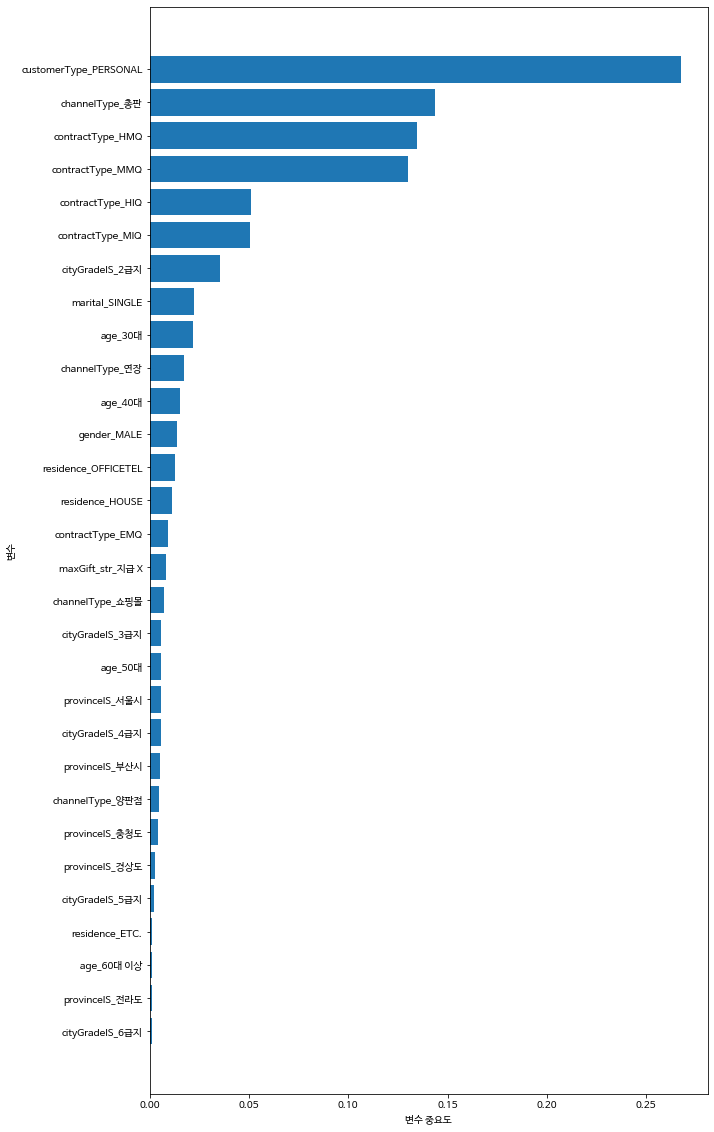

In [153]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates=range(len(df_importance))

# 변수중요도 차트
plt.figure(figsize=(10,20))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')